# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae

import pickle

In [3]:
def print_metrics(name, series, forecast):
  print(name + ' metrics:')
  print('MAPE = {:.2f}%'.format(mape(series, forecast)))
  print('RMSE = {:.2f}'.format(rmse(series, forecast)))
  print('MSE = {:.2f}'.format(mse(series, forecast)))
  print('MAE = {:.2f}'.format(mae(series, forecast)))
  print('')


In [4]:
def plot_forecast(series, forecast, title):
    plt.figure(figsize=(25,5))
    series.plot(label="actual")
    forecast.plot(label="forecast")
    plt.title(title)
    plt.legend()
    plt.show()


In [5]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
df = df[['ds', 'Global_active_power']]

/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_72069/1877659380.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_72069/1877659380.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})


In [6]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df.head(100)

,ds,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
95,2006-12-16 18:59:00,4.224
96,2006-12-16 19:00:00,4.070
97,2006-12-16 19:01:00,3.612
98,2006-12-16 19:02:00,3.458


In [7]:
# count NA values
df.isna().sum() / len(df)

ds                     0.000000
Global_active_power    0.012518
dtype: float64

In [8]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

In [9]:
TRAIN_DAYS = 60
PREDICTION_HOURS = 24

In [10]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.slice_n_points_before(series.end_time(), TRAIN_DAYS*24*60)

series = series.resample('10min', method='pad')

In [11]:
print(len(series))

8641


<Axes: xlabel='ds'>

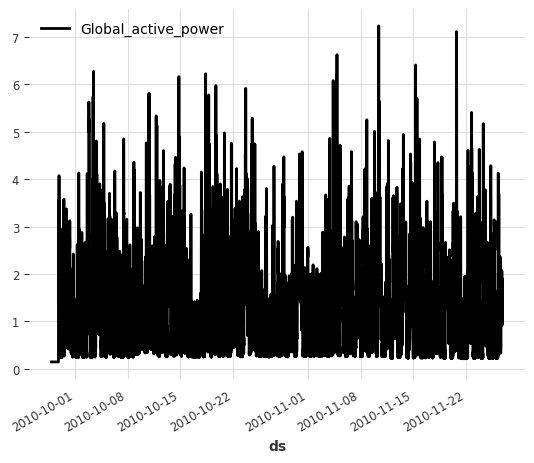

In [12]:
series.plot()

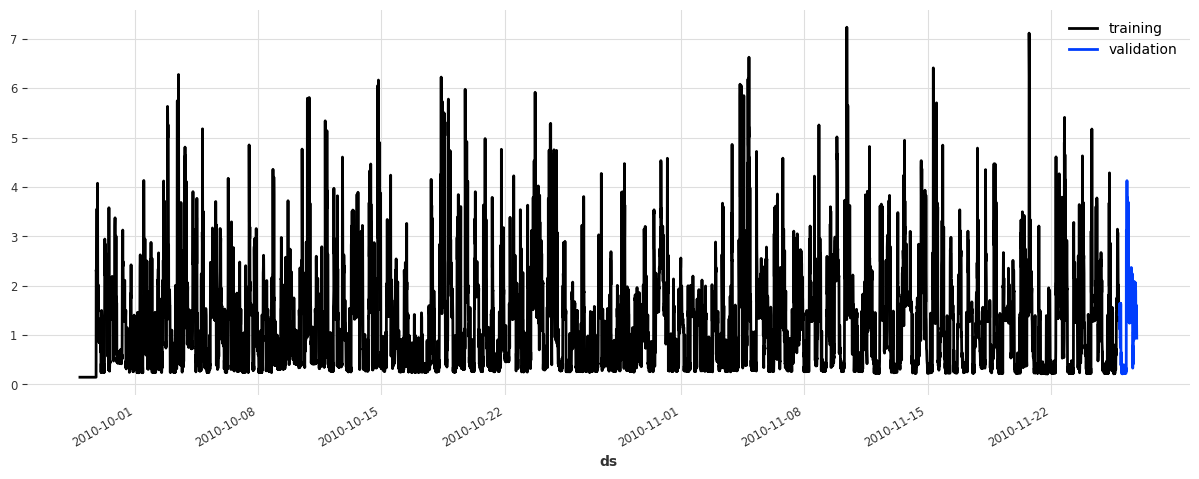

In [13]:
train, val = series.split_after((TRAIN_DAYS - 1) / TRAIN_DAYS)
plt.figure(figsize=(15, 5))
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)

## Baseline Model

<Axes: xlabel='ds'>

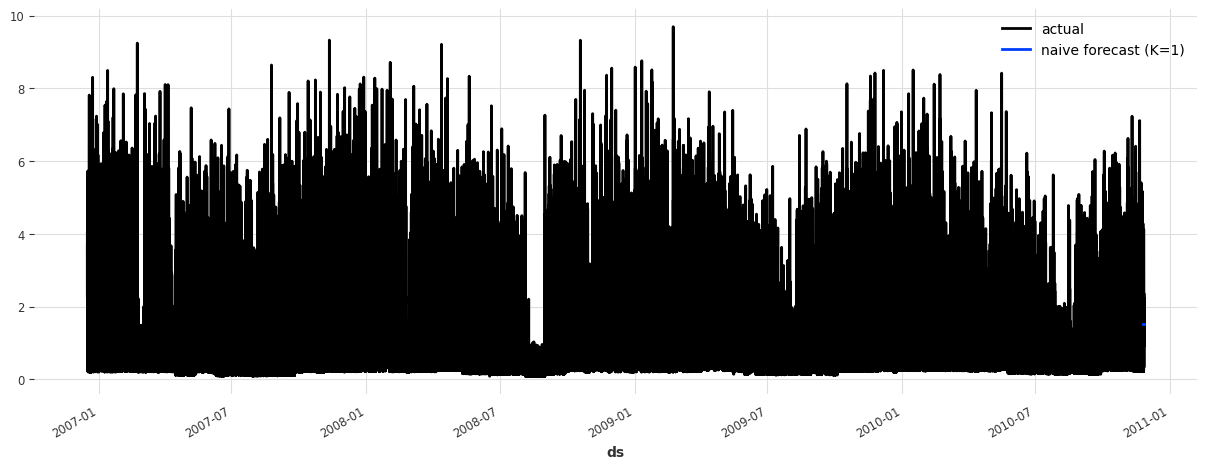

In [35]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
plt.figure(figsize=(15, 5))
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [37]:
from darts.models.forecasting.xgboost import XGBModel

try:
    with open('xgb_model.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
except FileNotFoundError:
    xgb_model = None

if xgb_model is not None:
    print('xgb_model loaded')
else:
    xgb_model = XGBModel(
        lags=24 * 7 * 6,
        output_chunk_length=100,
    )
    xgb_model.fit(train, verbose=True)

    pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))

xgb_forecast = xgb_model.predict(to_predict)


xgb_model loaded


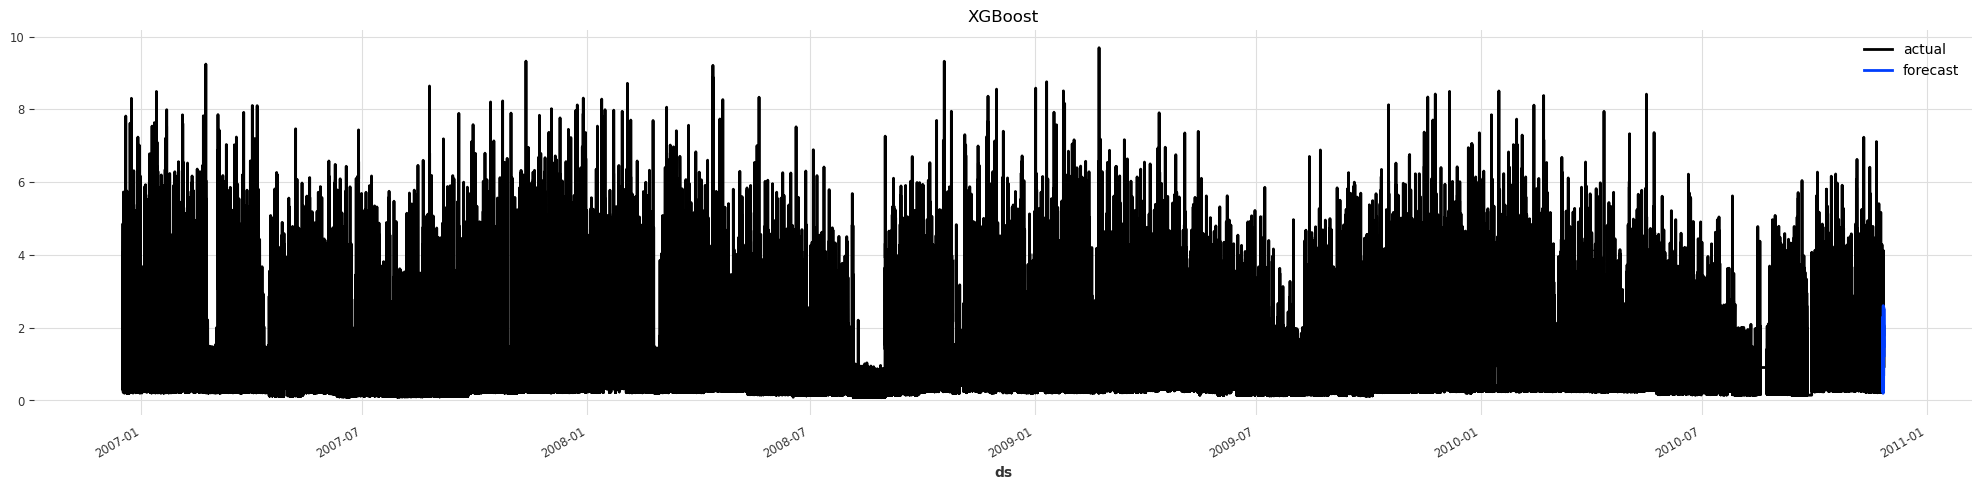

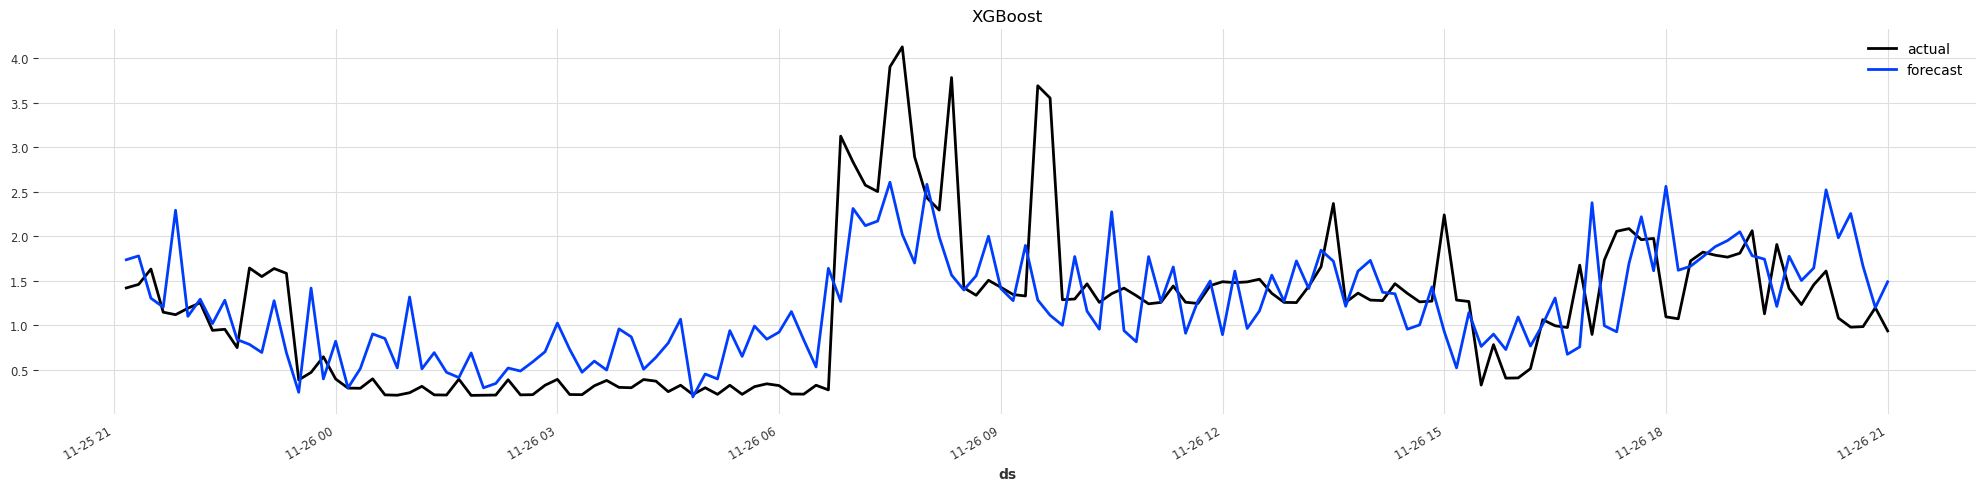

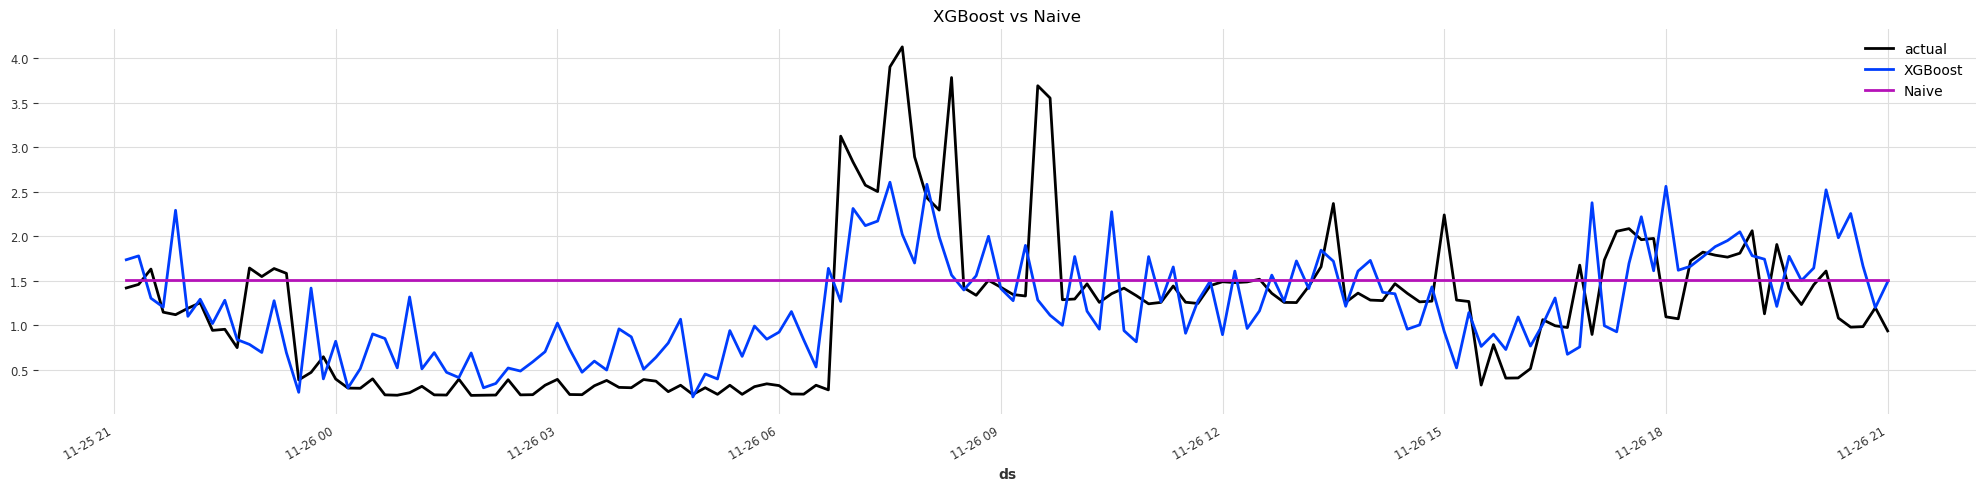

In [38]:
series_after_train = series.slice_intersect(val)
plot_forecast(series, xgb_forecast, "XGBoost")
plot_forecast(series_after_train, xgb_forecast, "XGBoost")

# plot xgboost forecast with naive on the same plot not using plot_forecast
plt.figure(figsize=(25,5))
series_after_train.plot(label="actual")
xgb_forecast.plot(label="XGBoost")
naive_forecast.plot(label="Naive")
plt.title("XGBoost vs Naive")
plt.legend()
plt.show()


In [17]:
print_metrics('XGBoost', val, xgb_forecast)
print_metrics('Naive', val, naive_forecast)

XGBoost metrics:
MAPE = 68.67%
RMSE = 0.67
MSE = 0.45
MAE = 0.48

Naive metrics:
MAPE = 156.78%
RMSE = 0.90
MSE = 0.80
MAE = 0.70



# Time GPT

In [39]:
from nixtlats import TimeGPT  # Importing the TimeGPT class from nixtlats library.


In [40]:
timegpt = TimeGPT(token='PhNfTNR2XMPBjg2SOPUhTGZOsXBpEb7xACBnmIRe9d0jVEyjpvVAADwgybFJlEP83VlYlFARir7WmHTJSpllDmqXC4wEv90l6X0w0mFrdRb0wcVy6Spu9dj4FvDSx7D6qIBy4eEmYR2B3HQhF7Q3wtAiThUeDUig8ZILY01TBSNWKJq1o8R2YxB9lbJfmOEVNc2FUVZWho6si8D551CvFMBOyZpTCJepHl7Em5w7jPTTZV26lveWP5lmEH6vIzpy')

In [41]:
if timegpt.validate_token():
    print("Token validation successful!")  # Token is valid.
else:
    # Raise an exception if token validation fails.
    raise Exception("Token validation failed! Please check go to https://dashboard.nixtla.io/ to get your token.")


INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


Token validation successful!


### load full dataset to train predict with GPT model

In [49]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.resample('10min', method='pad')

train, val = series.split_after((len(series) - 200) / len(series))
series_after_train = series.slice_intersect(val)


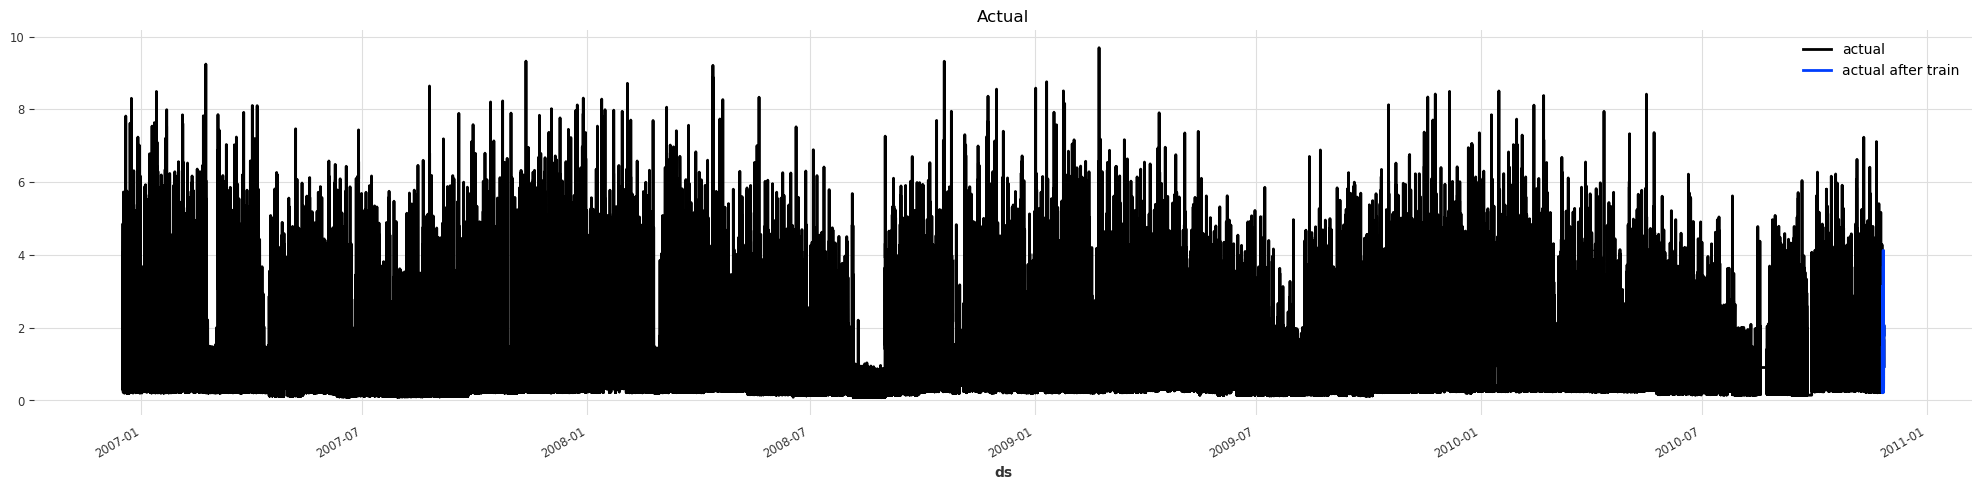

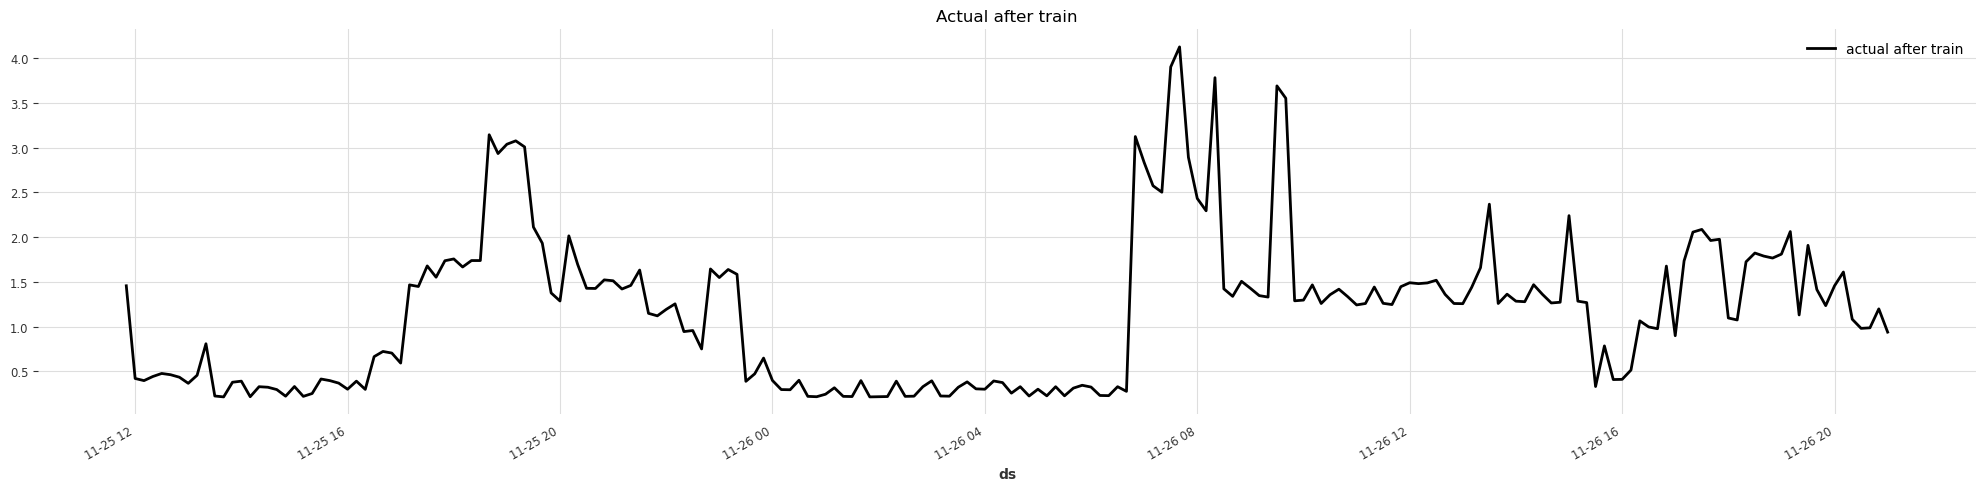

In [50]:
# plot the series and series_after_train
plt.figure(figsize=(25,5))
series.plot(label="actual")
series_after_train.plot(label="actual after train")
plt.title("Actual")
plt.legend()

# plot series_after_train
plt.figure(figsize=(25,5))
series_after_train.plot(label="actual after train")
plt.title("Actual after train")
plt.legend()


In [51]:

# to pandas dataframe
train_df = train.pd_dataframe().dropna()

# make index as separate column named timestamp
train_df['timestamp'] = train_df.index

# rename column Global_active_power to value
train_df = train_df.rename(columns={'Global_active_power': 'value'})

# drop index
train_df = train_df.reset_index(drop=True)

In [52]:
forecasts = []

for i in range(10, len(series_after_train), 20):
  print('fetching predictions for', i)

  if (i < 40):
    forecast = timegpt.forecast(df=train_df, h=i, time_col='timestamp', target_col='value', id_col='timestamp', fewshot_loss='mse', fewshot_steps=10)
  else:
    forecast = timegpt.forecast(df=train_df, h=i, time_col='timestamp', target_col='value', id_col='timestamp', fewshot_loss='mse', model='long-horizon', fewshot_steps=10)

  forecasts.append(forecast)

  forecast.to_csv('data/timegpt_full_forecast_' + str(i) + '.csv', index=False)
  print('saved forecast for', i)


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


fetching predictions for 10


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 10
fetching predictions for 30


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 30
fetching predictions for 50


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 50
fetching predictions for 70


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 70
fetching predictions for 90


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 90
fetching predictions for 110


INFO:nixtlats.timegpt:Inferred freq: 10T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


saved forecast for 110
fetching predictions for 130


INFO:nixtlats.timegpt:Inferred freq: 10T


ApiError: status_code: 429, body: {'status': 429, 'data': None, 'message': 'Too many requests', 'details': 'You need to add a payment method to continue using the API, do so from https://dashboard.nixtla.io', 'code': 'A21', 'support': 'If you have questions or need support, please email ops@nixtla.io', 'requestID': '97EC3WPNTT'}

## TimeGTP taught on whole dataset

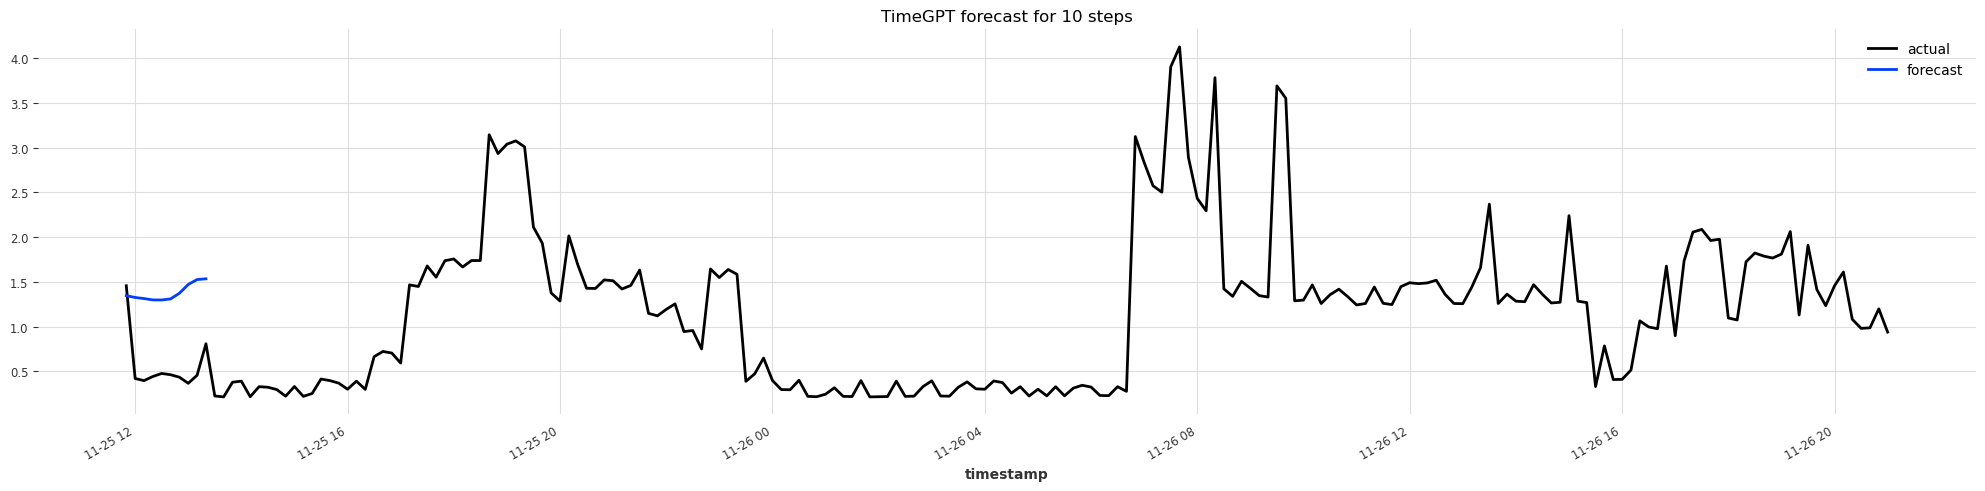

TimeGPT 10 metrics:
MAPE = 184.69%
RMSE = 0.87
MSE = 0.76
MAE = 0.83




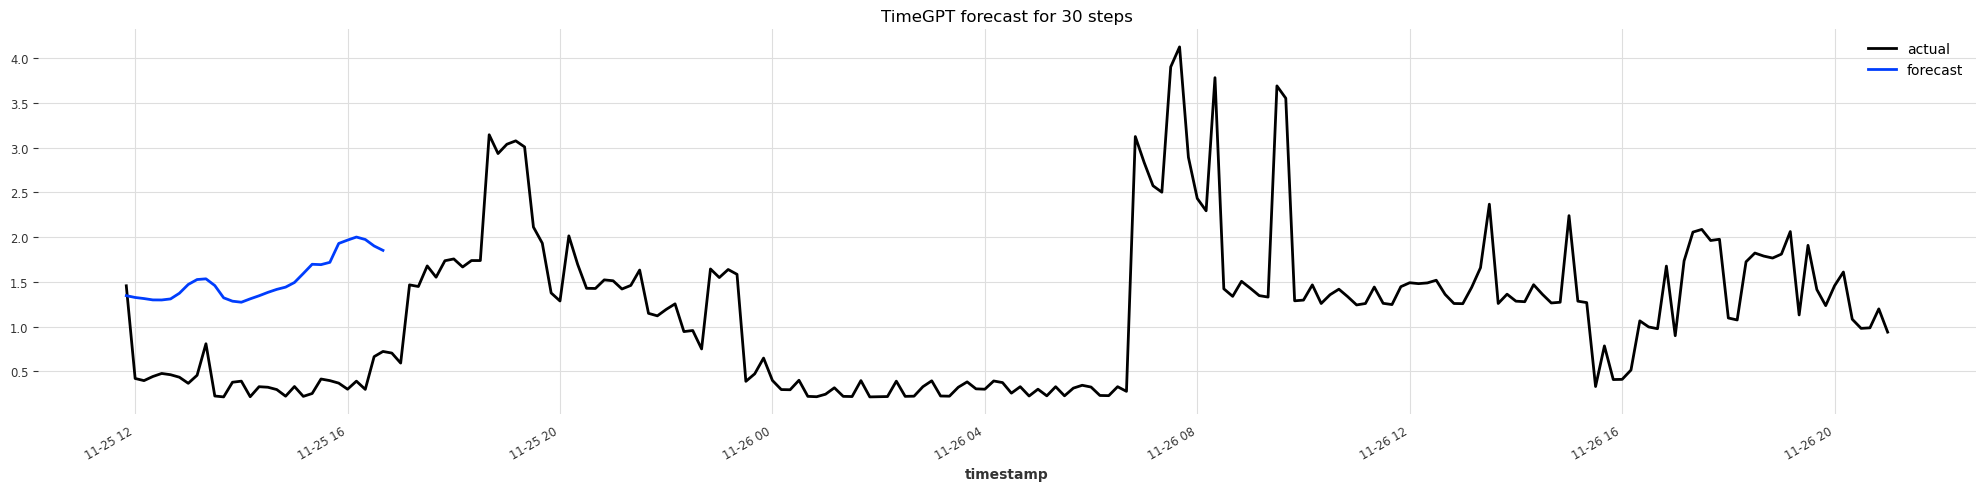

TimeGPT 30 metrics:
MAPE = 331.49%
RMSE = 1.16
MSE = 1.34
MAE = 1.11




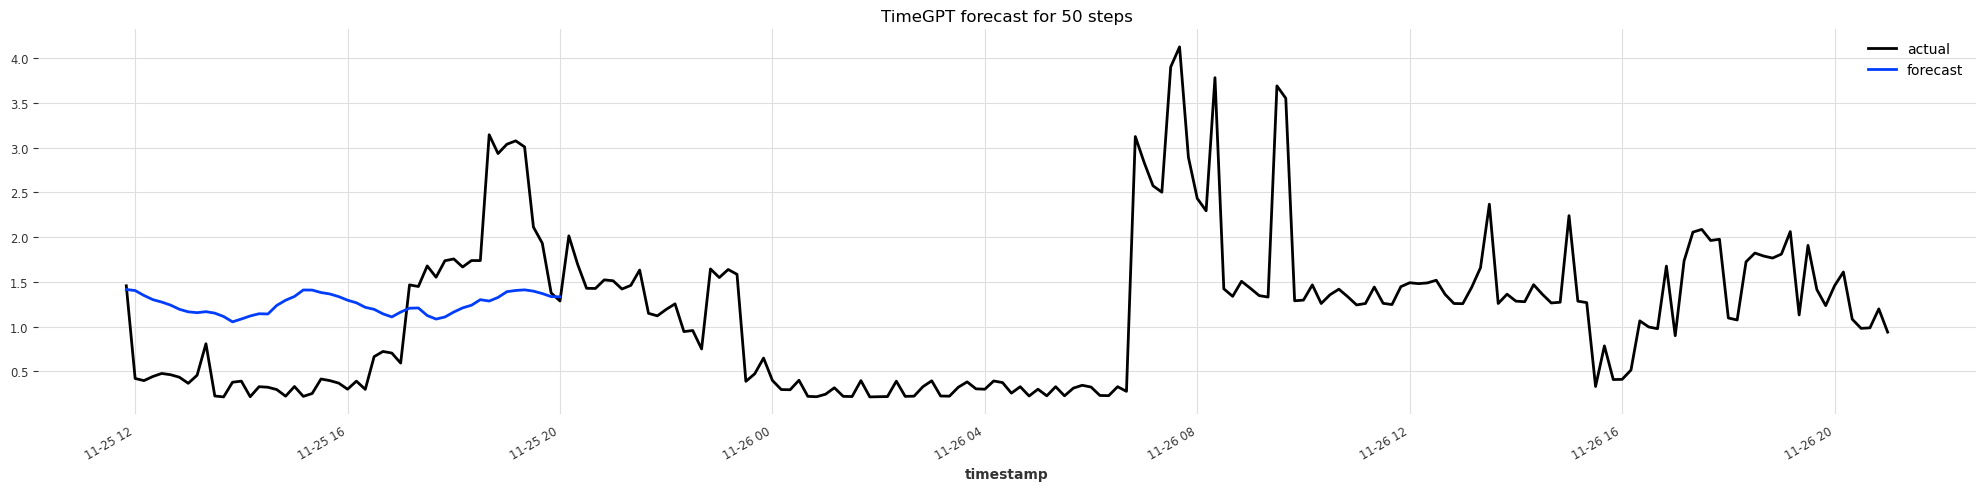

TimeGPT 50 metrics:
MAPE = 166.10%
RMSE = 0.89
MSE = 0.79
MAE = 0.79




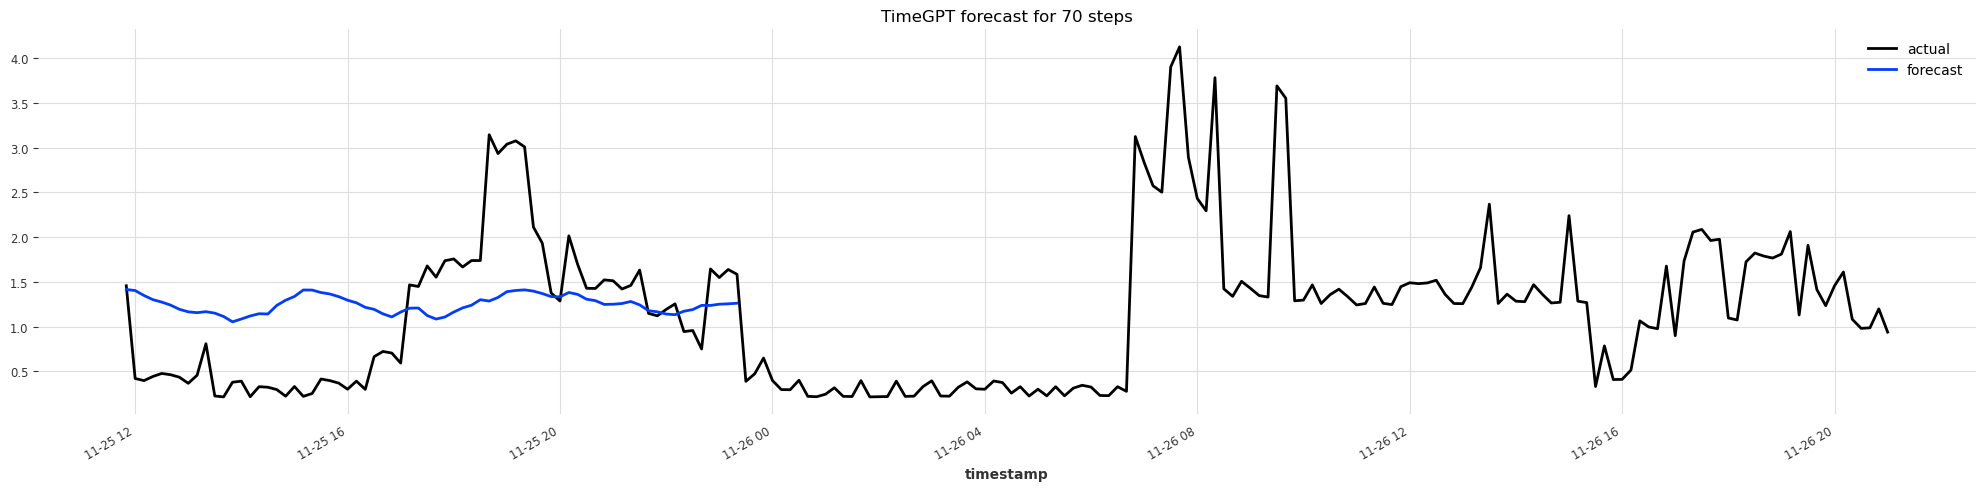

TimeGPT 70 metrics:
MAPE = 123.99%
RMSE = 0.77
MSE = 0.59
MAE = 0.64




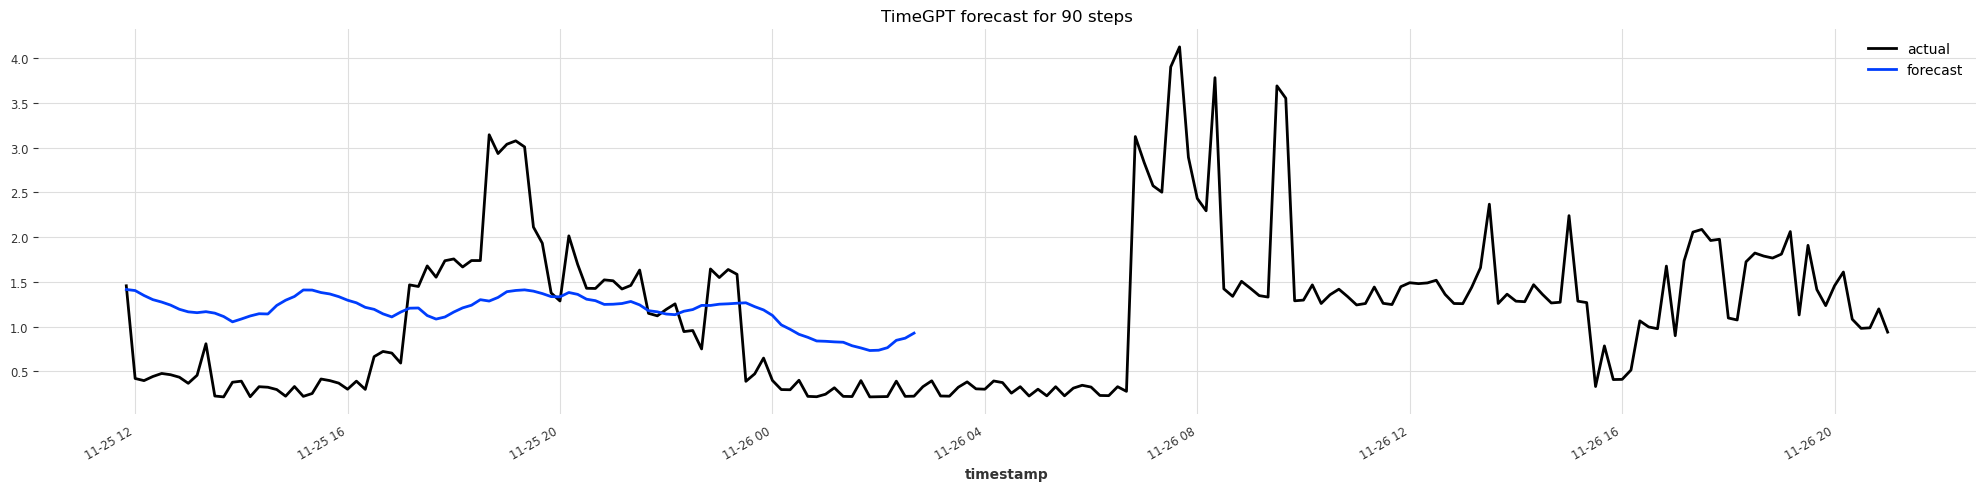

TimeGPT 90 metrics:
MAPE = 144.63%
RMSE = 0.74
MSE = 0.54
MAE = 0.63




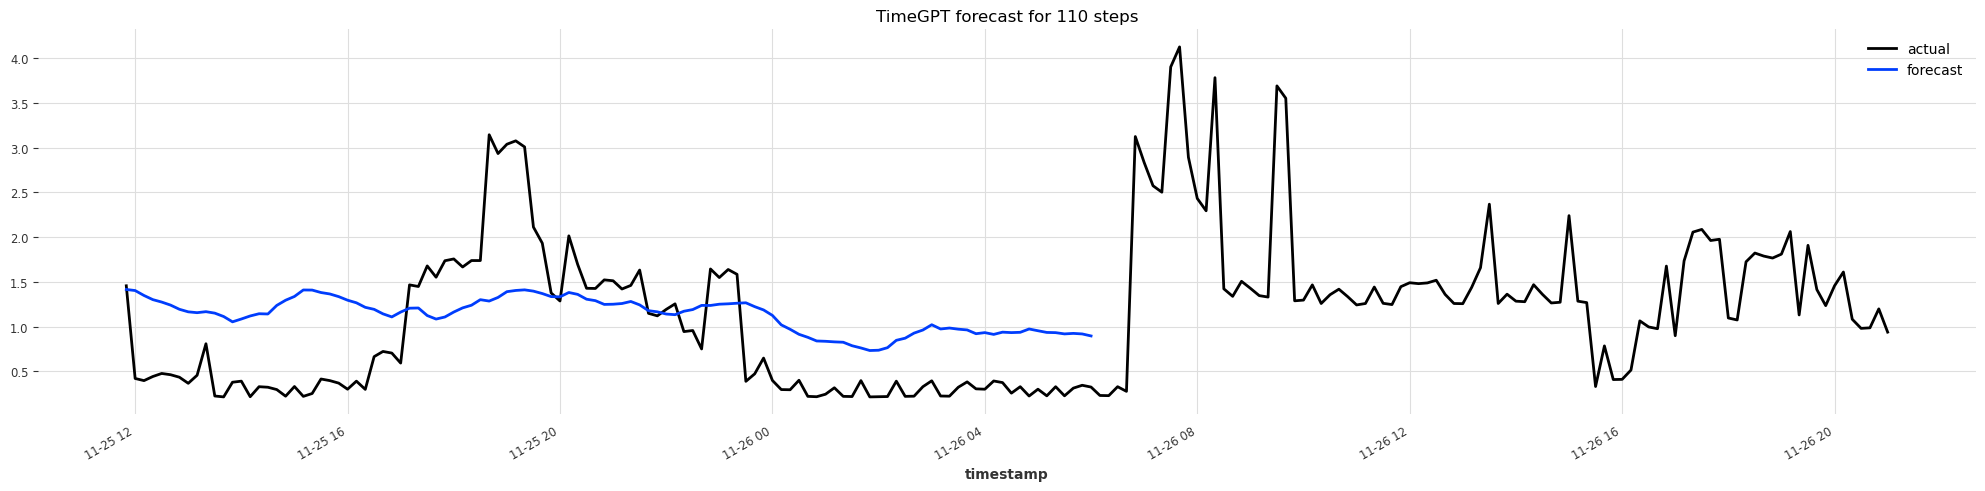

TimeGPT 110 metrics:
MAPE = 158.57%
RMSE = 0.72
MSE = 0.52
MAE = 0.63


forecast file not found for 130
forecast file not found for 150
forecast file not found for 170
forecast file not found for 190


In [54]:
# read forecasts timegpt_forecast_*.csv and plot them agains series_after_train
for i in range(10, len(series_after_train), 20):
  # check if the forecast file exists
  try:
    forecast_df = pd.read_csv('data/timegpt_full_forecast_' + str(i) + '.csv')
  except FileNotFoundError:
    print('forecast file not found for', i)
    continue

  forecast = TimeSeries.from_dataframe(forecast_df, time_col='timestamp', value_cols='TimeGPT')
  plot_forecast(series_after_train, forecast, "TimeGPT forecast for " + str(i) + " steps")

  print_metrics('TimeGPT ' + str(i), series_after_train, forecast)

  print('')

## TimeGPT taught on last 60 days

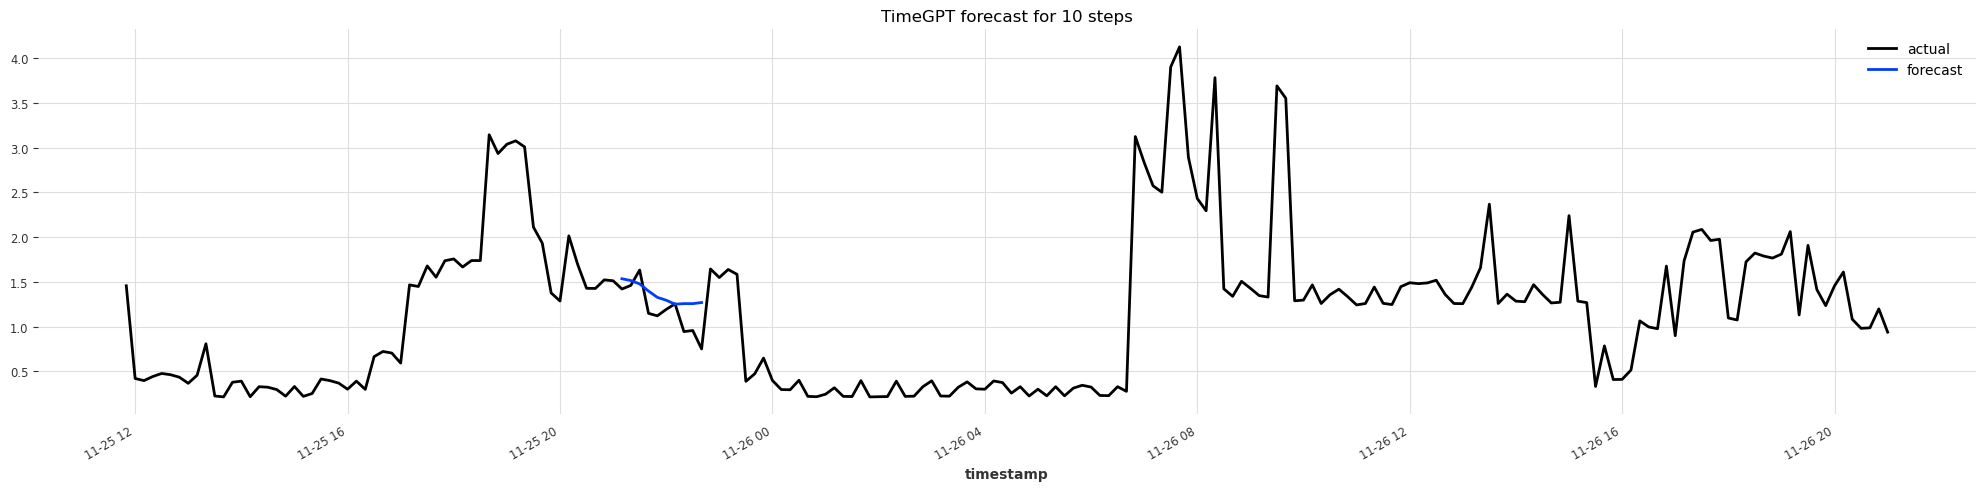

TimeGPT 10 metrics:
MAPE = 20.40%
RMSE = 0.25
MSE = 0.06
MAE = 0.20




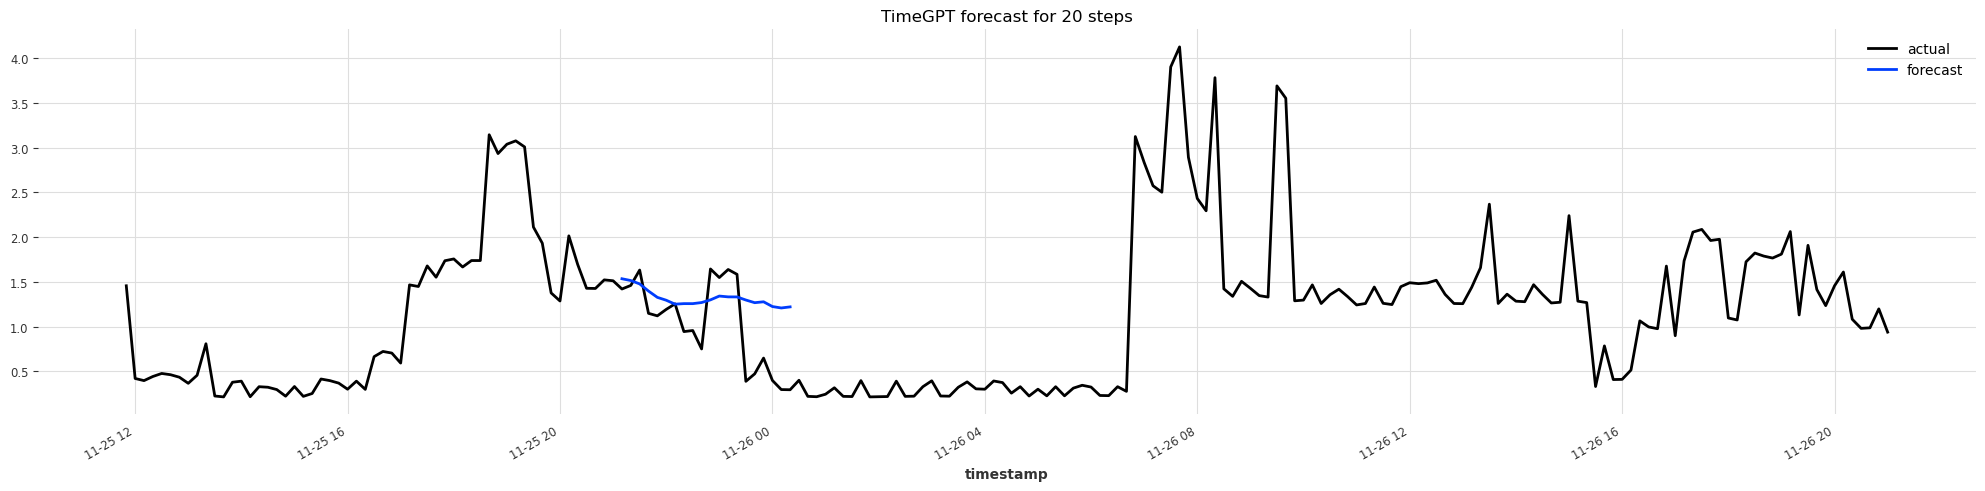

TimeGPT 20 metrics:
MAPE = 80.17%
RMSE = 0.51
MSE = 0.26
MAE = 0.41




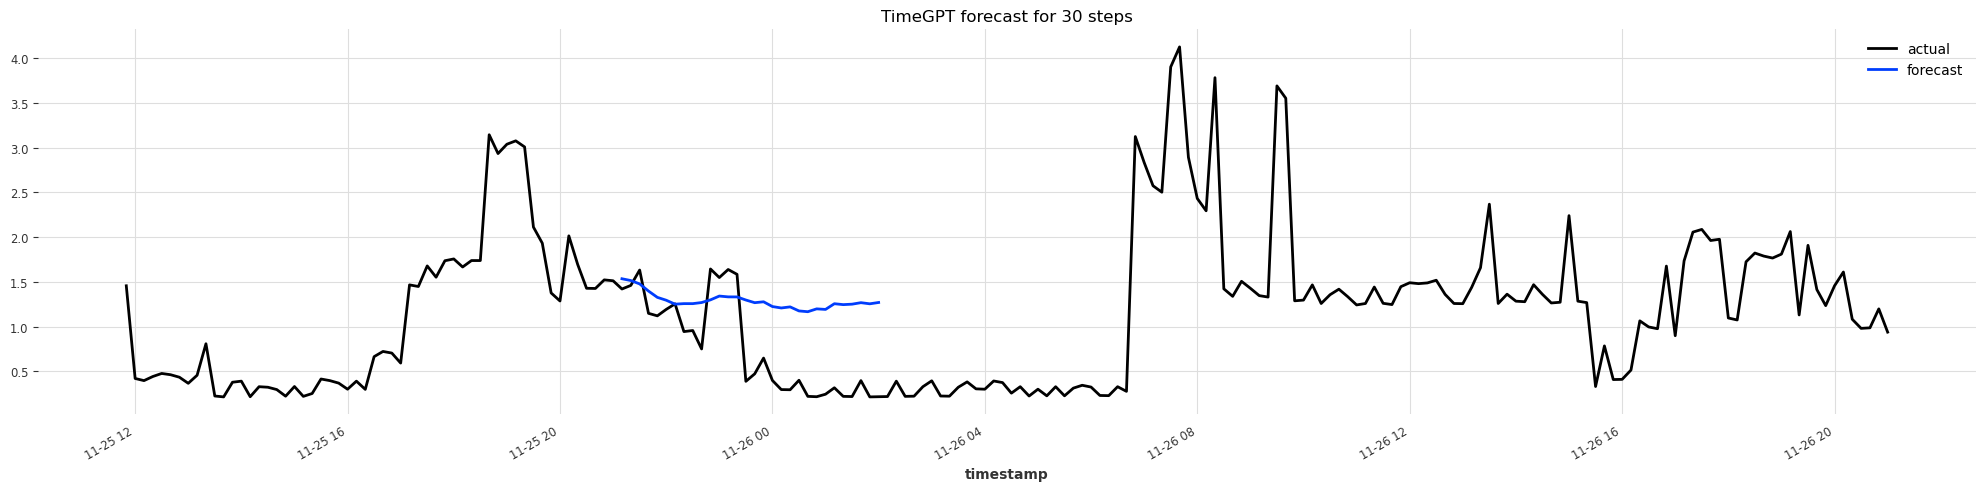

TimeGPT 30 metrics:
MAPE = 183.37%
RMSE = 0.69
MSE = 0.48
MAE = 0.59




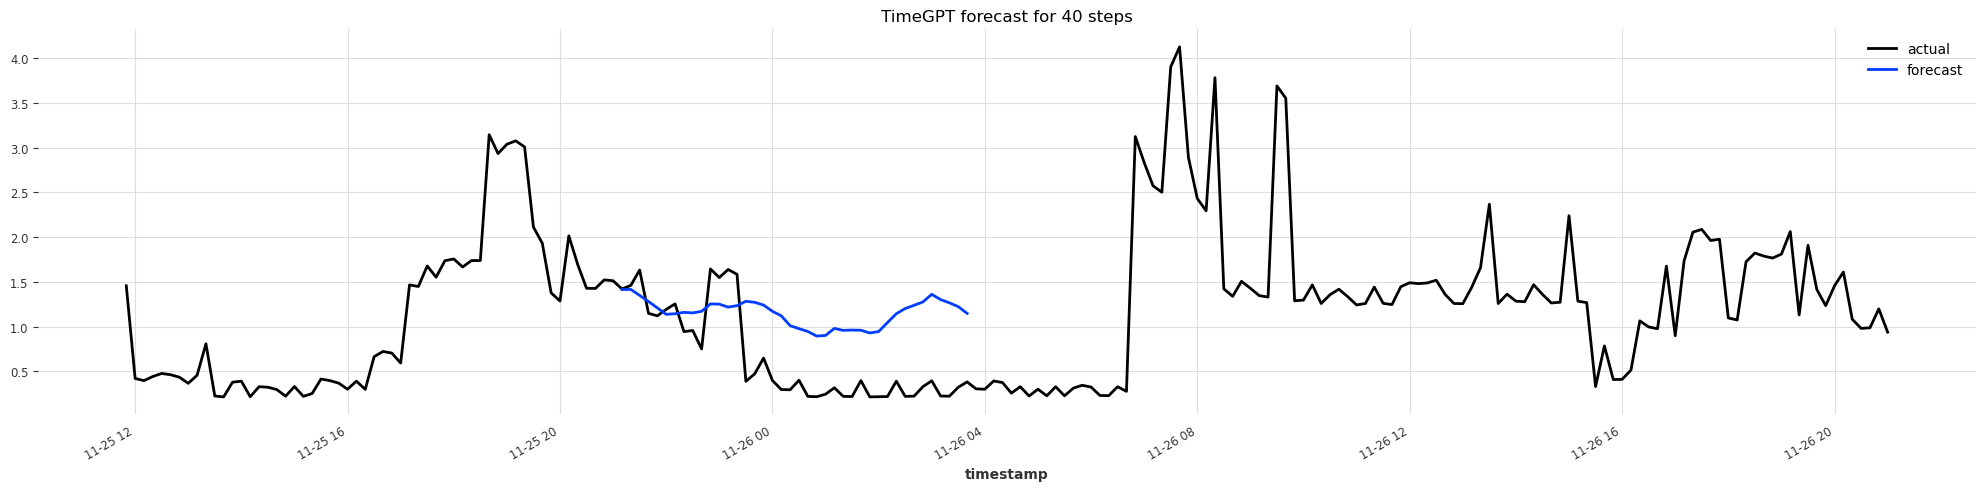

TimeGPT 40 metrics:
MAPE = 191.25%
RMSE = 0.67
MSE = 0.45
MAE = 0.59




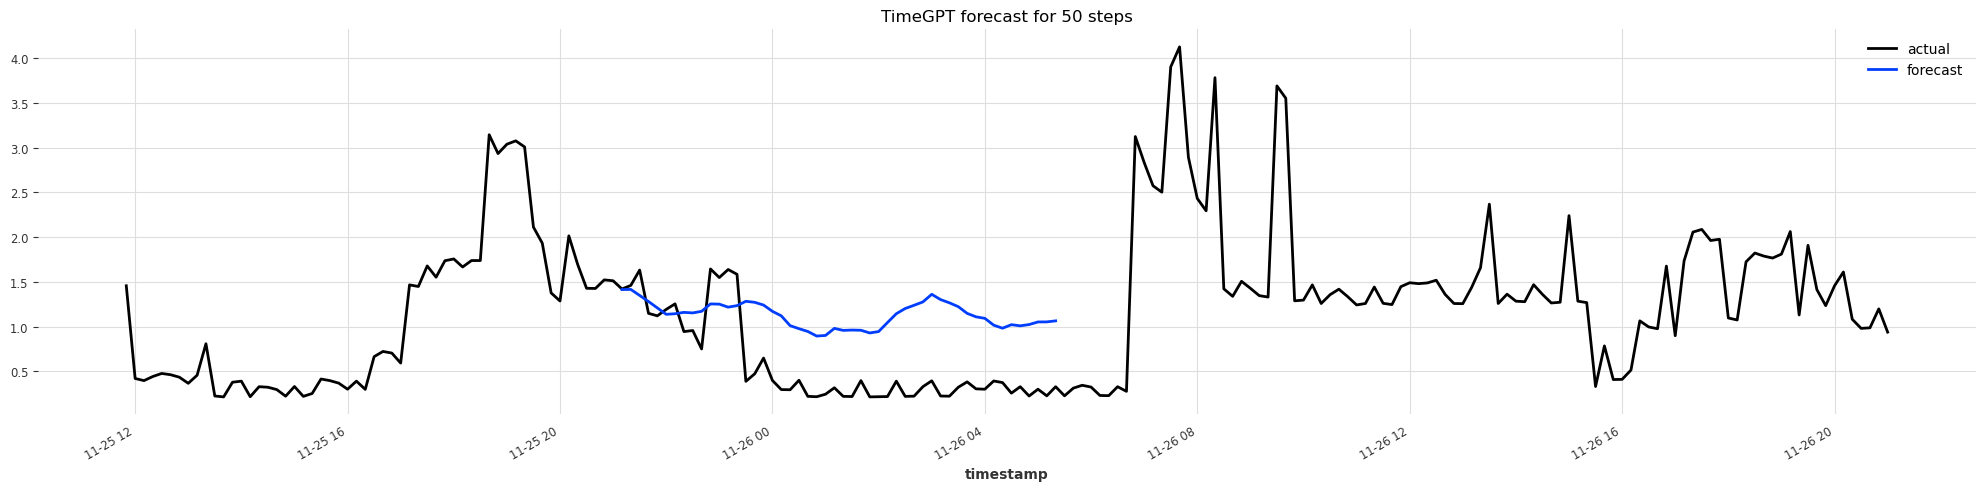

TimeGPT 50 metrics:
MAPE = 204.08%
RMSE = 0.68
MSE = 0.47
MAE = 0.62




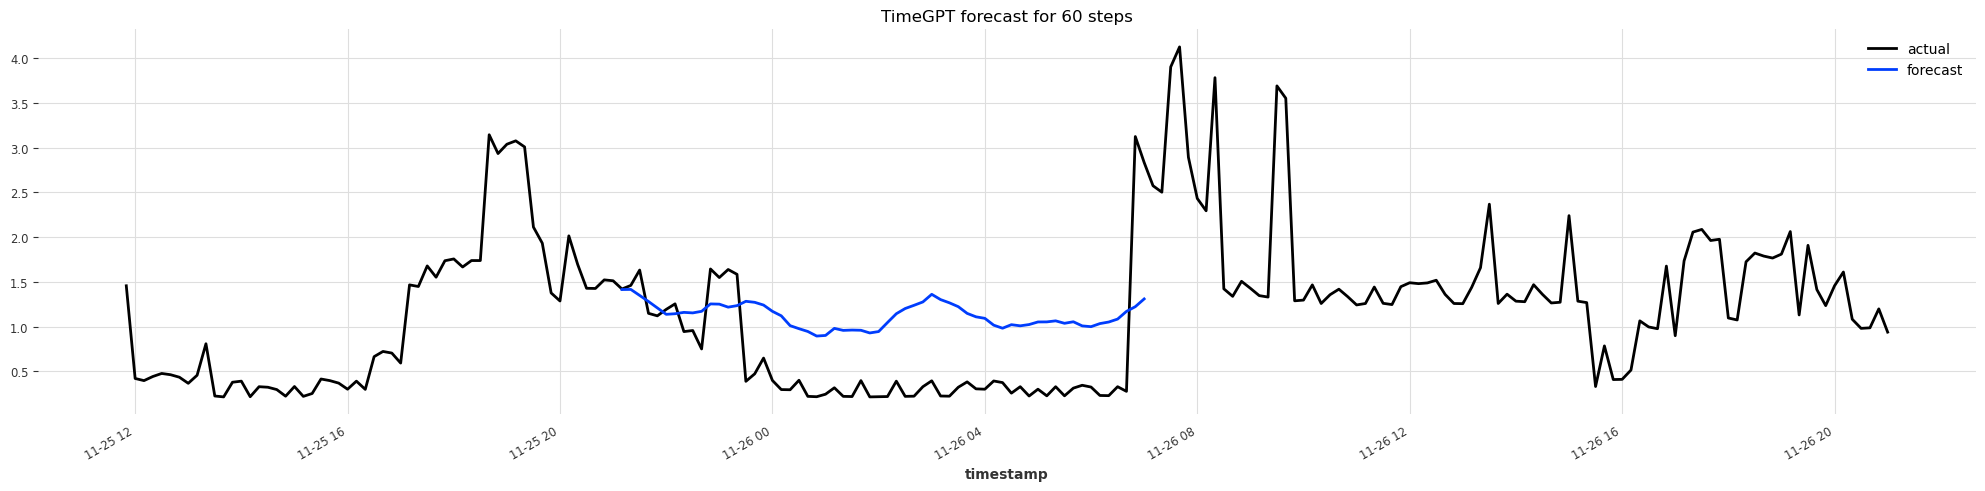

TimeGPT 60 metrics:
MAPE = 209.68%
RMSE = 0.75
MSE = 0.57
MAE = 0.68




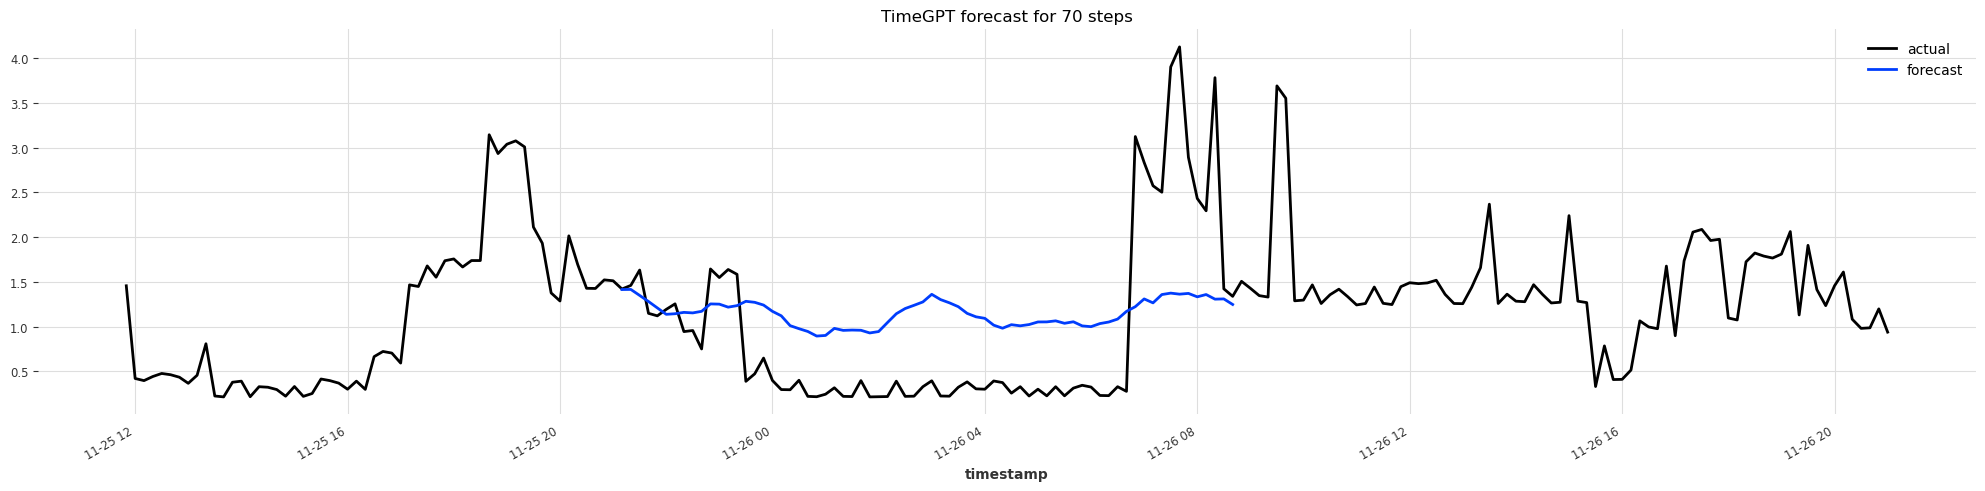

TimeGPT 70 metrics:
MAPE = 186.12%
RMSE = 0.94
MSE = 0.88
MAE = 0.78


forecast file not found for 80
forecast file not found for 90
forecast file not found for 100
forecast file not found for 110
forecast file not found for 120
forecast file not found for 130
forecast file not found for 140
forecast file not found for 150
forecast file not found for 160
forecast file not found for 170
forecast file not found for 180
forecast file not found for 190


In [55]:
for i in range(10, len(series_after_train) , 10):
  try:
    forecast_df = pd.read_csv('data/timegpt_forecast_' + str(i) + '.csv')
  except FileNotFoundError:
    print('forecast file not found for', i)
    continue

  forecast = TimeSeries.from_dataframe(forecast_df, time_col='timestamp', value_cols='TimeGPT')
  plot_forecast(series_after_train, forecast, "TimeGPT forecast for " + str(i) + " steps")

  print_metrics('TimeGPT ' + str(i), series_after_train, forecast)

  print('')

## TimeGPT results
The shorter the prediction horizon, the better the performance of TimeGPT. The best performance is achieved with a prediction horizon of 10 step ahead. taught on the last 60 days dataset
Also, the price of requests is humongous:
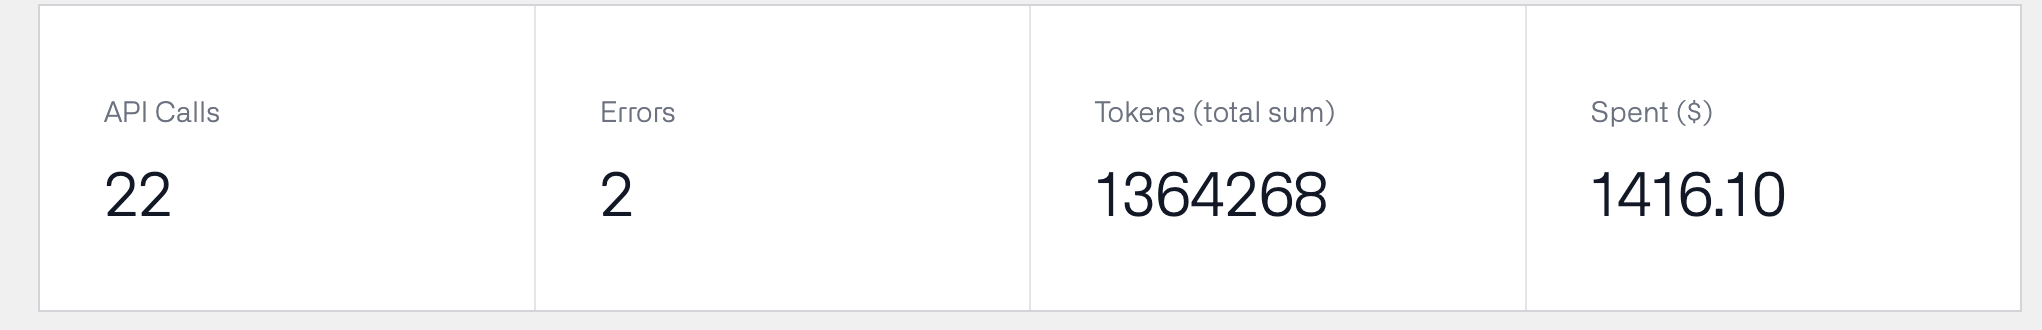

# Arima

In [19]:
print(train)

<TimeSeries (DataArray) (ds: 8497, component: 1, sample: 1)> Size: 68kB
array([[[  nan]],

       [[0.146]],

       [[0.146]],

       ...,

       [[1.426]],

       [[1.522]],

       [[1.512]]])
Coordinates:
  * ds         (ds) datetime64[ns] 68kB 2010-09-27T21:00:00 ... 2010-11-25T21...
  * component  (component) object 8B 'Global_active_power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [18]:
# arima model
from darts.models import AutoARIMA

model = AutoARIMA(verbose=True)
model.fit(train)

prediction = model.predict(to_predict, verbose=True)

ValueError: Input y contains NaN.

<Axes: xlabel='ds'>

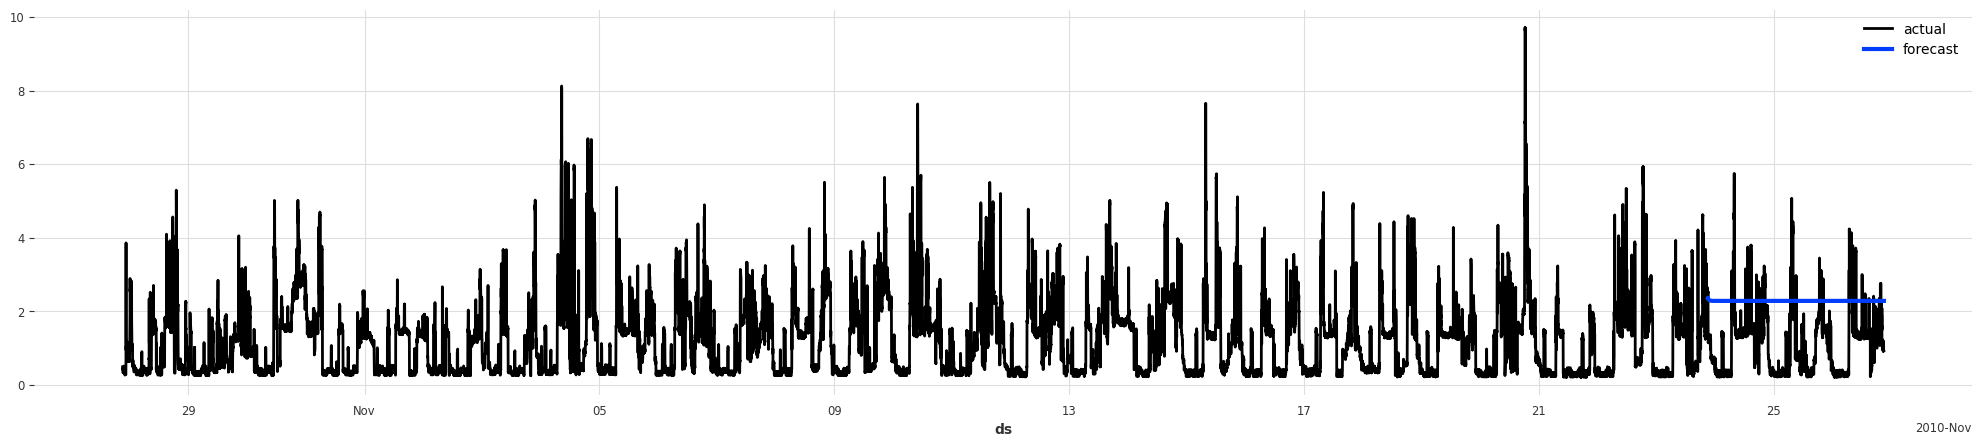

In [ ]:

plt.figure(figsize=(25,5))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)

In [ ]:
# exponential smoothing

from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing(seasonal_periods=7)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.9, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")

  0%|          | 0/1009 [00:00<?, ?it/s]

KeyboardInterrupt: 